In [31]:
import tensorflow as tf
import numpy as np
from NeuralFlow.flow import Flow_v2

In [32]:
def create_base_model(input_shape=1, output_shape=1):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)


In [33]:
flow = Flow_v2(
    model_fn = create_base_model,
    n_models = 3,
    noise_stddev=1e-4, 
    lam = 1e-2)

In [34]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def optimizer_fn():
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.96)
    return tf.keras.optimizers.Adam(lr_scheduler)

flow.compile(optimizer_fn=optimizer_fn, loss_fn=loss_fn, metrics=['mae'])

In [35]:
X_train = tf.cast(np.linspace(0, 1, 1000).reshape(-1, 1), tf.float32)
y_train = tf.cast(np.sin(X_train * 2 * np.pi).reshape(-1, 1), tf.float32)

batch_size = 32
loader_size = X_train.shape[0] // batch_size

In [36]:
flow.fit(X_train, y_train, batch_size=batch_size, epochs=10)

Epoch 1/10


32/32 - 1s - 31ms/step - loss: 1311.1417 - mae: 0.4381
Epoch 2/10
32/32 - 0s - 4ms/step - loss: 429.5464 - mae: 0.2221
Epoch 3/10
32/32 - 0s - 5ms/step - loss: 323.2237 - mae: 0.1562
Epoch 4/10
32/32 - 0s - 5ms/step - loss: 287.0156 - mae: 0.1245
Epoch 5/10
32/32 - 0s - 5ms/step - loss: 280.2565 - mae: 0.1173
Epoch 6/10
32/32 - 0s - 5ms/step - loss: 279.1868 - mae: 0.1210
Epoch 7/10
32/32 - 0s - 5ms/step - loss: 279.2352 - mae: 0.1241
Epoch 8/10
32/32 - 0s - 5ms/step - loss: 276.2027 - mae: 0.1216
Epoch 9/10
32/32 - 0s - 5ms/step - loss: 274.2331 - mae: 0.1219
Epoch 10/10
32/32 - 0s - 6ms/step - loss: 268.5668 - mae: 0.1193
Epoch 1/10
32/32 - 1s - 36ms/step - loss: 1690.7129 - mae: 0.5045
Epoch 2/10
32/32 - 0s - 4ms/step - loss: 569.7662 - mae: 0.2820
Epoch 3/10
32/32 - 0s - 5ms/step - loss: 354.2563 - mae: 0.1882
Epoch 4/10
32/32 - 0s - 5ms/step - loss: 283.6589 - mae: 0.1382
Epoch 5/10
32/32 - 0s - 6ms/step - loss: 266.2636 - mae: 0.1235
Epoch 6/10
32/32 - 0s - 6ms/step - loss: 260.7

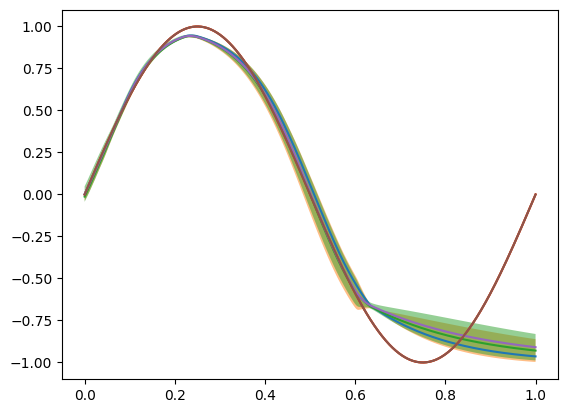

In [ ]:
import matplotlib.pyplot as plt


fig = plt.figure()
for n in range(10):
    est = flow.get_estimator("deep_ensemble", n_models = n)
    mean, var = est(X_train)

    # for model in flow.models:
    #     plt.plot(X_train, model(X_train), alpha=0.5)

    plt.plot(X_train, mean.squeeze())
    plt.fill_between(tf.squeeze(X_train), mean.squeeze() - 1.96 * np.sqrt(var.squeeze()),  mean.squeeze() + 1.96 * np.sqrt(var.squeeze()), alpha=0.5)


    plt.plot(X_train, y_train)

plt.show()